### Machine Learning Engineer Capstone Project 

## Project: Dog Identification App 

In this notebook, I will develop an algorithm to estimate the dog's breed. This algorithm will be composed of a dog detector and a human detector. If a dog is detected in the input image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most similar.

### Roadmap

* [First](#step1):  Import Datasets 
* [Second](#step2): Transform the data
* [Third](#step3):  Upload to S3
* [Fourth](#step4):  Implement dog detector
* [Fifth](#step5): Implement the human face detector
* [Sixth](#step6):  Implement dog breed estimator

<a id='step1'></a>

## 1<sup>st</sup>: Import datasets

The datasets that I will use are obtained from:
* [Standford database for dog breeds images](https://www.kaggle.com/c/7327/download-all) dataset from kaggle competition
* the human images from "[Labeled Faced in the Wild](http://vis-www.cs.umass.edu/lfw/)".

For dog-breed dataset, I will download the file from stanford site. The zip file will be upload to the jupiter notebook repository and then I must unzip the file. For each image, there are two files the image file and the annotation file, which contains a description of the image. We'll need this file for the dog detector.

In [1]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar

--2020-01-15 21:42:54--  http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 793579520 (757M) [application/x-tar]
Saving to: ‘images.tar’

images.tar          100%[===================>] 756.82M  5.61MB/s    in 1m 45s  

2020-01-15 21:44:39 (7.21 MB/s) - ‘images.tar’ saved [793579520/793579520]

--2020-01-15 21:44:39--  http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21852160 (21M) [application/x-tar]
Saving to: ‘annotation.tar’

annotation.tar      100%[===================>]  20.84M  10.7MB/s    in 1.9s    

2020-01-15 21:44:41 (10.7 MB/s) - ‘annotat

Now we make the directories that we need to transform the data and divide it into train and validation data. We also decompress the data.

In [19]:
!mkdir dogs_data
!mkdir dogs_data/generated
!mkdir dogs_data/train
!mkdir dogs_data/train_annotation
!mkdir dogs_data/validation
!mkdir dogs_data/validation_annotation
!tar -xf images.tar -C dogs_data/
!tar -xf annotation.tar -C dogs_data/

For the Human datasets, I will use the "Labeled Faced in the Wild" dataset. And We'll make the directory structure for it.

In [136]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2020-01-25 07:21:33--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  55.4MB/s    in 3.4s    

2020-01-25 07:21:36 (51.3 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [139]:
!mkdir face_data
!mkdir face_data/images
!mkdir face_data/generated
!mkdir face_data/train
!mkdir face_data/train_annotation
!mkdir face_data/validation
!mkdir face_data/validation_annotation
!tar -zxvf lfw.tgz -C face_data/

lfw/
lfw/George_HW_Bush/
lfw/George_HW_Bush/George_HW_Bush_0001.jpg
lfw/George_HW_Bush/George_HW_Bush_0002.jpg
lfw/George_HW_Bush/George_HW_Bush_0003.jpg
lfw/George_HW_Bush/George_HW_Bush_0004.jpg
lfw/George_HW_Bush/George_HW_Bush_0005.jpg
lfw/George_HW_Bush/George_HW_Bush_0006.jpg
lfw/George_HW_Bush/George_HW_Bush_0007.jpg
lfw/George_HW_Bush/George_HW_Bush_0008.jpg
lfw/George_HW_Bush/George_HW_Bush_0009.jpg
lfw/George_HW_Bush/George_HW_Bush_0010.jpg
lfw/George_HW_Bush/George_HW_Bush_0011.jpg
lfw/George_HW_Bush/George_HW_Bush_0012.jpg
lfw/George_HW_Bush/George_HW_Bush_0013.jpg
lfw/Curtis_Strange/
lfw/Curtis_Strange/Curtis_Strange_0001.jpg
lfw/Marc_Grossman/
lfw/Marc_Grossman/Marc_Grossman_0001.jpg
lfw/Marc_Grossman/Marc_Grossman_0002.jpg
lfw/Marc_Grossman/Marc_Grossman_0003.jpg
lfw/Marc_Grossman/Marc_Grossman_0004.jpg
lfw/Michael_Schumacher/
lfw/Michael_Schumacher/Michael_Schumacher_0001.jpg
lfw/Michael_Schumacher/Michael_Schumacher_0002.jpg
lfw/Michael_Schumacher/Michael_Schumacher_00

<a id='step2'></a>
## 2<sup>nd</sup>: Transform the data

In this section, we will transform the dog dataset and the face dataset. We need making several files that sagemaker use to construct the model.

In [4]:
import numpy as np

from PIL import Image

import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import torch

import os
from xml.dom import minidom
import json
import shutil
from random import shuffle

### Dog Data

First I'll made a dictionary of the dog's categories that we have.

In [5]:
dogs_categories = {}
category_counter = 0
for name in os.listdir("./dogs_data/Annotation"): 
    if os.path.isdir("./dogs_data/Annotation/"+name):
        dogs_categories[name[10:]] = category_counter
        category_counter += 1

I'll use the sagemaker object detection algorithm, and we need a json annotation file with a certain structure. With this code I'll made this files with the xml file provided for Stanford.

In [22]:
for directory in os.listdir("./dogs_data/Annotation"): 
    annotation_directory = "./dogs_data/Annotation/"+directory
    if os.path.isdir(annotation_directory):
        for file in os.listdir(annotation_directory):
            if os.path.isfile(annotation_directory+"/"+file):
                # parse an xml file by name
                mydoc = minidom.parse(annotation_directory+"/"+file)
                fileName =file
                jsonFile = fileName +'.json'
                line = {}
                # move image to upper directory
                shutil.move('./dogs_data/Images/'+directory+'/'+fileName+'.jpg', './dogs_data/Images/')
                # build the json required
                line['file'] = fileName+".jpg"
                line['image_size'] = [{
                    'width':int(mydoc.getElementsByTagName('width')[0].firstChild.data),
                    'height':int(mydoc.getElementsByTagName('height')[0].firstChild.data),
                    'depth':mydoc.getElementsByTagName('depth')[0].firstChild.data
                }]
                line['annotations'] = []
                for box in mydoc.getElementsByTagName('bndbox'):
                    line['annotations'].append({
                        'class_id':int(dogs_categories[mydoc.getElementsByTagName('name')[0].firstChild.data]),
                        'top':int(mydoc.getElementsByTagName('bndbox')[0].childNodes[1].firstChild.data),
                        'left':int(mydoc.getElementsByTagName('bndbox')[0].childNodes[3].firstChild.data),
                        'width':int(mydoc.getElementsByTagName('bndbox')[0].childNodes[5].firstChild.data),
                        'height':int(mydoc.getElementsByTagName('bndbox')[0].childNodes[7].firstChild.data)})
                line['categories']=[]
                line['categories'].append({
                    'class_id':int(dogs_categories[mydoc.getElementsByTagName('name')[0].firstChild.data]),
                    'name':mydoc.getElementsByTagName('name')[0].firstChild.data
                })
                if line['annotations']:
                    with open(os.path.join('./dogs_data/generated', jsonFile),'w') as p:
                        json.dump(line,p)

With this cell, I'll do some cleaning of the files in the workspace.

In [23]:
# delete directories
for directory in os.listdir("./dogs_data/Images"): 
    images_directory = "./dogs_data/Images/"+directory
    if os.path.isdir(images_directory):
        shutil.rmtree(images_directory)

Check the files in directories and shuffle the data for divide into train and validations datasets.

In [24]:
path, dirs, files = next(os.walk('./dogs_data/Images'))

print ('There are {} images in directory'.format(len(files)))

jsons = os.listdir('./dogs_data/generated')

print ('There are {} images have annotation files'.format(len(jsons)))

shuffle(jsons)

There are 20580 images in directory
There are 20581 images have annotation files


In [42]:
train_jsons = jsons[:16464]
val_jsons = jsons[16464:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './dogs_data/Images/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './dogs_data/train/')
    shutil.move('./dogs_data/generated/'+i, './dogs_data/train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './dogs_data/Images/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './dogs_data/validation/')
    shutil.move('./dogs_data/generated/'+i, './dogs_data/validation_annotation/')

### Face Data

The face dataset doesn't have an annotation file, and I'll use the same detector algorithm from Amazon Sagemaker. I'll make the annotation files and will group all the files in the same directory.

In [154]:
for directory in os.listdir("./face_data/lfw"): 
    person_directory = "./face_data/lfw/"+directory
    if os.path.isdir(person_directory):
        for file in os.listdir(person_directory):
            if os.path.isfile(person_directory+"/"+file):
                jsonFile = file.split(".")[0] +'.json'
                line = {}
                # build the json required
                line['file'] = file
                im = Image.open(person_directory+"/"+file)
                w,h = im.size
                line['image_size'] = [{
                    'width':int(w),
                    'height':int(h),
                    'depth':im.bits
                }]
                line['annotations'] = []                
                line['annotations'].append({
                    'class_id':1,
                    'top':0,
                    'left':0,
                    'width':int(w),
                    'height':int(h)
                })
                line['categories']=[]
                line['categories'].append({
                    'class_id':1,
                    'name':'person'
                })
                if line['annotations']:
                    with open(os.path.join('./face_data/generated', jsonFile),'w') as p:
                        json.dump(line,p)                    
                # move image to upper directory
                shutil.move(person_directory+"/"+file, "./face_data/images/")

In [ ]:
# delete directories
for directory in os.listdir("./face_data/lfw"): 
    images_directory = "./face_data/lfw/"+directory
    if os.path.isdir(images_directory):
        shutil.rmtree(images_directory)

In [156]:
path, dirs, files = next(os.walk('./face_data/images'))

print ('There are {} images in directory'.format(len(files)))

jsons = os.listdir('./face_data/generated')

print ('There are {} images have annotation files'.format(len(jsons)))

shuffle(jsons)

There are 13233 images in directory
There are 13233 images have annotation files


Divide the dataset into train and validation datasets.

In [157]:
train_jsons = jsons[:11248]
val_jsons = jsons[11248:]

#Moving training files to the training folders
for i in train_jsons:
    image_file = './face_data/images/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './face_data/train/')
    shutil.move('./face_data/generated/'+i, './face_data/train_annotation/')

#Moving validation files to the validation folders
for i in val_jsons:
    image_file = './face_data/images/'+i.split('.')[0]+'.jpg'
    shutil.move(image_file, './face_data/validation/')
    shutil.move('./face_data/generated/'+i, './face_data/validation_annotation/')

<a id='step3'></a>
## 3<sup>rd</sup>: Transform the dataUpload to S3

First I'll load the libraries and get the role and the session for Sagemaker.

In [7]:
%%time
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
print(role)
sess = sagemaker.Session()
bucket = sess.default_bucket()

arn:aws:iam::491576157094:role/service-role/AmazonSageMaker-ExecutionRole-20191208T094449
CPU times: user 847 ms, sys: 118 ms, total: 965 ms
Wall time: 6.33 s


### Dogs detector

Define a prefix for the dataset into S3

In [10]:
prefix = 'Dogs-Breed'

And get the pretrained image for object detection in Sagemaker

In [8]:
dog_detector_training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print(dog_detector_training_image)

825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detection:latest


Now upload the data into S3, this is a requirement of the algorithm that I'll use, the data must be upload in S3 in these directories.

In [15]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

sess.upload_data(path='./dogs_data/train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='./dogs_data/validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='./dogs_data/train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='./dogs_data/validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_dogs_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_dogs_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_dogs_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_dogs_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 11.4 µs


In [11]:
s3_dogs_output_location = 's3://{}/{}/output'.format(bucket, prefix)

### Face detector

In [13]:
prefix = 'Face_detector'

face_detector_training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (face_detector_training_image)

825641698319.dkr.ecr.us-east-2.amazonaws.com/object-detection:latest


In [16]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

sess.upload_data(path='./face_data/train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='./face_data/validation', bucket=bucket, key_prefix=validation_channel)
sess.upload_data(path='./face_data/train_annotation', bucket=bucket, key_prefix=train_annotation_channel)
sess.upload_data(path='./face_data/validation_annotation', bucket=bucket, key_prefix=validation_annotation_channel)

s3_face_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_face_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_face_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_face_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.4 µs


In [14]:
s3_face_output_location = 's3://{}/{}/output'.format(bucket, prefix)

<a id='step4'></a>

## 4<sup>th</sup>: Implements Dogs Detector

I'll use the Sagemaker estimator for object detection, I have based my implementation on the algorithm [documentation in Sagemaker](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html)

In [18]:
dog_detector_model = sagemaker.estimator.Estimator(dog_detector_training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_dogs_output_location,
                                         sagemaker_session=sess)

I'll use a resnet-50 for the base network because it's a normal network for image analysis.

In [19]:
dog_detector_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=80,
                             mini_batch_size=16,
                             epochs=5,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=600,
                             num_training_samples=11248)

In [21]:
train_data = sagemaker.session.s3_input(s3_dogs_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_dogs_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_dogs_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_dogs_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

Now I'll start the model training

In [22]:
dog_detector_model.fit(inputs=data_channels, logs=True)

2020-01-26 12:24:45 Starting - Starting the training job...
2020-01-26 12:24:47 Starting - Launching requested ML instances...
2020-01-26 12:25:45 Starting - Preparing the instances for training.........
2020-01-26 12:26:47 Downloading - Downloading input data..................
2020-01-26 12:30:16 Training - Downloading the training image...
2020-01-26 12:30:35 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
[01/26/2020 12:30:39 INFO 140245856106304] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u

[01/26/2020 12:43:44 INFO 140245856106304] Epoch:    0, batches:    400, num_examples:   6400, 8.6 samples/sec, epoch time so far:  0:12:20.091571
[01/26/2020 12:46:42 INFO 140245856106304] Epoch:    0, batches:    500, num_examples:   8000, 8.7 samples/sec, epoch time so far:  0:15:17.610868
[01/26/2020 12:49:40 INFO 140245856106304] Epoch:    0, batches:    600, num_examples:   9600, 8.8 samples/sec, epoch time so far:  0:18:15.126814
[01/26/2020 12:52:37 INFO 140245856106304] Epoch:    0, batches:    700, num_examples:   11200, 8.8 samples/sec, epoch time so far:  0:21:12.552711
[01/26/2020 12:52:44 WARNING 140245856106304] Expected number of batches: 703, did not match the number of batches processed: 704. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/26/2020 12:52:44 INFO 140245856106304] #quality_metric: host=algo-1, epoch=0, batch=704 train cross_entropy <loss>

[01/26/2020 13:44:09 INFO 140245856106304] Epoch:    3, batches:    200, num_examples:   3200, 9.1 samples/sec, epoch time so far:  0:05:52.677942
[01/26/2020 13:47:05 INFO 140245856106304] Epoch:    3, batches:    300, num_examples:   4800, 9.1 samples/sec, epoch time so far:  0:08:49.279474
[01/26/2020 13:50:02 INFO 140245856106304] Epoch:    3, batches:    400, num_examples:   6400, 9.1 samples/sec, epoch time so far:  0:11:46.231868
[01/26/2020 13:52:59 INFO 140245856106304] Epoch:    3, batches:    500, num_examples:   8000, 9.1 samples/sec, epoch time so far:  0:14:42.944138
[01/26/2020 13:55:55 INFO 140245856106304] Epoch:    3, batches:    600, num_examples:   9600, 9.1 samples/sec, epoch time so far:  0:17:39.215263
[01/26/2020 13:58:52 INFO 140245856106304] Epoch:    3, batches:    700, num_examples:   11200, 9.1 samples/sec, epoch time so far:  0:20:36.053080
[01/26/2020 13:58:57 INFO 140245856106304] #quality_metric: host=algo-1, epoch=3, batch=703 train cross_entropy <loss

And now deploy the model

In [23]:
dog_detector = dog_detector_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

-------------!

In these cells we test the detector endpoint.

In [24]:
!wget -O test.jpg https://upload.wikimedia.org/wikipedia/commons/2/25/Affenpinscher_dog.jpg
file_name = './dogs_data/Images/n02085620_10074.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

--2020-01-26 15:22:34--  https://upload.wikimedia.org/wikipedia/commons/2/25/Affenpinscher_dog.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19258 (19K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  18.81K  --.-KB/s    in 0.05s   

2020-01-26 15:22:34 (415 KB/s) - ‘test.jpg’ saved [19258/19258]



In [25]:
dog_detector.content_type = 'image/jpeg'
results = dog_detector.predict(b)
detections = json.loads(results)
print (detections)

{'prediction': [[1.0, 0.9999821186065674, 0.0, 0.02528950572013855, 1.0, 0.9650051593780518], [1.0, 0.012816025875508785, 0.0, 0.6199274659156799, 0.6818828582763672, 0.960885226726532]]}


In [26]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : dict
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:            
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=3.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            key_list = list(classes.keys()) 
            val_list = list(classes.values()) 

            if classes and len(classes) > cls_id:
                class_name = key_list[val_list.index(cls_id)]
            print(class_name)
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

Rhodesian_ridgeback


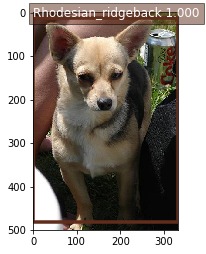

In [27]:
threshold = 0.05
  
# Visualize the detections.
visualize_detection(file_name, detections['prediction'], dogs_categories, threshold)

<a id='step5'></a>

## 5<sup>th</sup>: Implements Human Face Detector

Now I'll follow the same steps as in the dog detector

In [28]:
face_detector_model = sagemaker.estimator.Estimator(face_detector_training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_face_output_location,
                                         sagemaker_session=sess)

In [29]:
face_detector_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=1,
                             num_classes=1,
                             mini_batch_size=16,
                             epochs=5,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=600,
                             num_training_samples=16464)

In [30]:
train_data = sagemaker.session.s3_input(s3_face_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_face_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_face_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_face_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

Train the model

In [31]:
face_detector_model.fit(inputs=data_channels, logs=True)

2020-01-26 15:24:54 Starting - Starting the training job...
2020-01-26 15:24:56 Starting - Launching requested ML instances...
2020-01-26 15:25:54 Starting - Preparing the instances for training......
2020-01-26 15:26:50 Downloading - Downloading input data.....................
2020-01-26 15:30:12 Training - Downloading the training image..Docker entrypoint called with argument(s): train
[01/26/2020 15:30:35 INFO 139752898369344] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False', u'early_stopping_patience': u'5', u'momentum': u'0.9', u'num_training_samples': u'', u'optimizer': u'sgd', u'_tuning_o

[01/26/2020 15:42:31 INFO 139752898369344] Epoch:    0, batches:    400, num_examples:   6400, 9.6 samples/sec, epoch time so far:  0:11:09.679610
[01/26/2020 15:45:08 INFO 139752898369344] Epoch:    0, batches:    500, num_examples:   8000, 9.7 samples/sec, epoch time so far:  0:13:47.299813
[01/26/2020 15:47:46 INFO 139752898369344] Epoch:    0, batches:    600, num_examples:   9600, 9.8 samples/sec, epoch time so far:  0:16:24.411258
[01/26/2020 15:50:23 INFO 139752898369344] Epoch:    0, batches:    700, num_examples:   11200, 9.8 samples/sec, epoch time so far:  0:19:01.653473
[01/26/2020 15:50:29 WARNING 139752898369344] Expected number of batches: 1029, did not match the number of batches processed: 704. This may happen when some images or annotations are invalid and cannot be parsed. Please check the dataset and ensure it follows the format in the documentation.
[01/26/2020 15:50:29 INFO 139752898369344] #quality_metric: host=algo-1, epoch=0, batch=704 train cross_entropy <loss

[01/26/2020 16:33:51 INFO 139752898369344] Epoch:    3, batches:    100, num_examples:   1600, 10.2 samples/sec, epoch time so far:  0:02:36.977919
[01/26/2020 16:36:28 INFO 139752898369344] Epoch:    3, batches:    200, num_examples:   3200, 10.2 samples/sec, epoch time so far:  0:05:14.593360
[01/26/2020 16:39:06 INFO 139752898369344] Epoch:    3, batches:    300, num_examples:   4800, 10.2 samples/sec, epoch time so far:  0:07:52.175903
[01/26/2020 16:41:43 INFO 139752898369344] Epoch:    3, batches:    400, num_examples:   6400, 10.2 samples/sec, epoch time so far:  0:10:29.565548
[01/26/2020 16:44:21 INFO 139752898369344] Epoch:    3, batches:    500, num_examples:   8000, 10.2 samples/sec, epoch time so far:  0:13:07.029178
[01/26/2020 16:46:58 INFO 139752898369344] Epoch:    3, batches:    600, num_examples:   9600, 10.2 samples/sec, epoch time so far:  0:15:44.171739
[01/26/2020 16:49:35 INFO 139752898369344] Epoch:    3, batches:    700, num_examples:   11200, 10.2 samples/sec

Deploy the model

In [32]:
face_detector = face_detector_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

-------------!

In [35]:
file_name = './face_data/validation/Abdel_Nasser_Assidi_0002.jpg'

with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

In [36]:
face_detector.content_type = 'image/jpeg'
results = face_detector.predict(b)
detections = json.loads(results)
print (detections)

{'prediction': []}


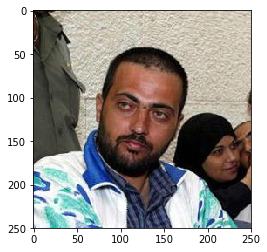

In [37]:
threshold = 0.05
  
# Visualize the detections.
visualize_detection(file_name, detections['prediction'], [0], threshold)

<a id='step6'></a>

## 6<sup>th</sup>: Implement Dogs Classification

For the dogs classification I'll use another algorithm from Amazon Sagemaker, the [Image Classification Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html).
To use this algorithm we need a lst file that contains all the files that we use and the category. So, I must create this files.


In [38]:
!mkdir dogs_data/train_lst
!mkdir dogs_data/validation_lst

mkdir: cannot create directory ‘dogs_data/train_lst’: File exists
mkdir: cannot create directory ‘dogs_data/validation_lst’: File exists


In [71]:
with open("./dogs_data/train_lst/dog_train.lst", "w+") as lst:
    index = 0
    for file in os.listdir("./dogs_data/train_annotation"):
        if os.path.isfile("./dogs_data/train_annotation/"+file):
            with open("./dogs_data/train_annotation/"+file, "r") as f:
                dog_dict = json.load(f)
                lst.write(("{}\t{}\t{}\n")
                          .format(index,dog_dict["categories"][0]["class_id"],file.split('.')[0]+".jpg"))
                index+=1
    lst.close
with open("./dogs_data/validation_lst/dog_validation.lst", "w+") as lst:
    index = 0
    for file in os.listdir("./dogs_data/validation_annotation"):
        if os.path.isfile("./dogs_data/validation_annotation/"+file):
            with open("./dogs_data/validation_annotation/"+file, "r") as f:
                dog_dict = json.load(f)
                lst.write(("{}\t{}\t{}\n")
                          .format(index,dog_dict["categories"][0]["class_id"],file.split('.')[0]+".jpg"))
                index+=1  
    lst.close


Now I'll get the pretrained model from Sagemaker.

In [72]:
training_classification_image = get_image_uri(sess.boto_region_name, 'image-classification', repo_version="latest")
print (training_classification_image)

825641698319.dkr.ecr.us-east-2.amazonaws.com/image-classification:latest


Upload the new file to S3.

In [86]:
%%time

prefix = 'Dogs-Breed'

sess = sagemaker.Session()
bucket = sess.default_bucket()

train_lst_channel = prefix + '/train_lsts'
validation_lst_channel = prefix + '/validation_lsts'

sess.upload_data(path='./dogs_data/train_lst', bucket=bucket, key_prefix=train_lst_channel)
sess.upload_data(path='./dogs_data/validation_lst', bucket=bucket, key_prefix=validation_lst_channel)

s3_classification_train_lst_data = 's3://{}/{}'.format(bucket, train_channel)
s3_classification_validation_lst_data = 's3://{}/{}'.format(bucket, validation_channel)

CPU times: user 149 ms, sys: 17.4 ms, total: 167 ms
Wall time: 466 ms


In [80]:
s3_classification_output_location = 's3://{}/{}/output'.format(bucket, prefix)

Create the model.

In [81]:
dog_classification_model = sagemaker.estimator.Estimator(training_classification_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p2.xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_classification_output_location,
                                         sagemaker_session=sess)

In [82]:
dog_classification_model.set_hyperparameters(num_layers=18,
                             use_pretrained_model=1,
                             image_shape = "3,224,224",
                             num_classes=257,
                             mini_batch_size=128,
                             epochs=2,
                             learning_rate=0.01,
                             top_k=2,
                             num_training_samples=15420,
                             resize = 256,
                             precision_dtype='float32')

And now I'll train the model with the data uploaded in S3

In [83]:
train_data = sagemaker.session.s3_input(s3_dogs_train_data, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_dogs_validation_data, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')
train_data_lst = sagemaker.session.s3_input(s3_classification_train_lst_data, distribution='FullyReplicated', 
                        content_type='application/x-image', s3_data_type='S3Prefix')
validation_data_lst = sagemaker.session.s3_input(s3_classification_validation_lst_data, distribution='FullyReplicated', 
                             content_type='application/x-image', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_lst': train_data_lst, 'validation_lst': validation_data_lst}

In [84]:
dog_classification_model.fit(inputs=data_channels, logs=True)

2020-01-26 18:16:35 Starting - Starting the training job...
2020-01-26 18:16:36 Starting - Launching requested ML instances...
2020-01-26 18:17:33 Starting - Preparing the instances for training............
2020-01-26 18:19:09 Downloading - Downloading input data..................
2020-01-26 18:22:31 Training - Downloading the training image...
2020-01-26 18:23:02 Uploading - Uploading generated training model
2020-01-26 18:23:02 Failed - Training job failed
Docker entrypoint called with argument(s): train
[01/26/2020 18:22:54 INFO 139807908677440] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/image_classification/default-input.json: {u'beta_1': 0.9, u'gamma': 0.9, u'beta_2': 0.999, u'optimizer': u'sgd', u'use_pretrained_model': 0, u'eps': 1e-08, u'epochs': 30, u'lr_scheduler_factor': 0.1, u'num_layers': 152, u'image_shape': u'3,224,224', u'precision_dtype': u'float32', u'mini_batch_size': 32, u'weight_decay': 0.0001, u'learning_rate': 0.1, u'momentum': 0}


UnexpectedStatusException: Error for Training job image-classification-2020-01-26-18-16-35-736: Failed. Reason: ClientError: imread read blank (None) image for file: /opt/ml/input/data/train/n02105412_1106.jpg

Now deploy the model.

In [ ]:
dog_classification_classifier = dog_classification_model.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

Finally, I'll delete all the endpoint in Sagemaker 

In [2]:
sagemaker.Session().delete_endpoint(dog_detector.endpoint)
sagemaker.Session().delete_endpoint(face_detector.endpoint)
sagemaker.Session().delete_endpoint(dog_classification_classifier.endpoint)

NameError: name 'sagemaker' is not defined